In [55]:
import os
import datetime
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
    

In [ ]:
# # Dataset and run parameters
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "lstm-100percent"  # Change as desired
# year = "2018"
# model = "lstm"  # Change as desired

# # Define output folder and create it
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

import os

# 1. Parameters and Setup
dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
sample_fraction = 0.005  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
run_name = "lstm_run1-100percent"  # Change as desired
model = "lstm"  # Change as desired

# Extract the entire filename (without the extension) from the dataset_path.
filename = os.path.basename(dataset_path)  # e.g., "2018.csv"
csv_name = os.path.splitext(filename)[0]    # e.g., "2018" or "MyDataset" if the file is named that way

# Use csv_name as the dynamic folder name
output_folder = os.path.join("Outputs", csv_name, model, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)

Output folder created: Outputs/LSTM/lstm_run2-100percent


In [57]:
# 2. Data Loading & Preprocessing
data_full = pd.read_csv(dataset_path)
print("Original dataset shape:", data_full.shape)
print("First few rows:")
print(data_full.head())
print("Dataset info:")
print(data_full.info())
print("Class distribution:")
print(data_full['label'].value_counts())

# Sample a fraction of the dataset
data = data_full.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

del data_full

# Remove any unwanted rows (e.g., header row misread as data)
data = data[data['label'] != 'label']

# %% [code]
# Encode labels dynamically
data['label'], uniques = pd.factorize(data['label'])
label_names = {i: label for i, label in enumerate(uniques)}
print("Encoded labels mapping:")
print(label_names)

# %% [code]
# Select relevant features
# Here we choose all columns except 'timestamp' and 'Label'
# (You can override this by defining a list manually)
selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'label']]
print("Selected features:")
print(selected_features)





Original dataset shape: (4339650, 26)
First few rows:
    timestamp  Dst Port  protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1519094835      53.0        17         1868.0                    652825.2   
1  1519128805     445.0         6      1252729.0                  11573211.5   
2  1519097277      53.0        17          280.0                    579726.2   
3  1519123005      53.0        17          394.0                     52952.9   
4  1518745532      80.0         6        39031.0                     19442.9   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.095075e+06           1.0           1.0             43.0   
1               3.551231e+07           7.0           5.0            364.0   
2               1.223813e+06           1.0           1.0             42.0   
3               1.573216e+05           1.0           1.0             48.0   
4               1.858333e+04           3.0           4.0            345.0   

  

In [58]:
# # Attempt to convert the 'protocol' column to numeric, storing the result in a new column
# data['protocol_numeric'] = pd.to_numeric(data['protocol'], errors='coerce')

# # Identify rows where conversion failed (non-numeric values)
# failing_rows = data[data['protocol_numeric'].isna() & data['protocol'].notna()]

# print("Rows with non-numeric 'protocol' values:")
# print(failing_rows)

In [59]:
# # Now, if you're satisfied, drop these rows
# data = data.dropna(subset=['protocol_numeric'])

# # Optionally, replace the original 'protocol' column with the numeric version and cast to int
# data['protocol'] = data['protocol_numeric'].astype(int)
# data = data.drop(columns=['protocol_numeric'])

# print("\nCleaned protocol column unique values:")
# print(data['protocol'].unique())
# print("\nCleaned protocol column value counts:")
# print(data['protocol'].value_counts())

# # Save the cleaned dataset to a new CSV file
# cleaned_dataset_path = "/Users/rooj/Documents/RP3-Main/RP3-Imp/clean-datasets/2018_protocol_cleaned.csv"
# data.to_csv(cleaned_dataset_path, index=False)
# print("Cleaned dataset saved to:", cleaned_dataset_path)

In [60]:
X = data[selected_features]
y = data['label']

# Handle missing values
num_rows_before = X.shape[0]
X = X.dropna()
num_rows_after = X.shape[0]
print("Number of rows dropped due to missing values:", num_rows_before - num_rows_after)

# Print all unique values in the 'protocol' column
print("Unique values in 'protocol':")
print(data['protocol'].unique())
# Print the count of each unique value
print("\nValue counts in 'protocol':")
print(data['protocol'].value_counts())

Number of rows dropped due to missing values: 0
Unique values in 'protocol':
[ 6 17]

Value counts in 'protocol':
protocol
6     3432523
17     907127
Name: count, dtype: int64


In [61]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [62]:
# 4. Time-Series Windowing Function
def create_sequences(X, y, timesteps):
    """Convert data into overlapping sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - timesteps + 1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1])  # Use the label of the last timestep as the sequence label
    return np.array(Xs), np.array(ys)

window_size = 10  # Number of timesteps per sequence
X_seq, y_seq = create_sequences(X_scaled, y, timesteps=window_size)
print("Windowed data shape:", X_seq.shape)  # (num_samples, timesteps, num_features)

Windowed data shape: (4339641, 10, 24)


In [63]:
# 5. Train-Test Split (Time-based Split)
# Here, we assume the data is time-ordered. We split into 80% train and 20% test.
split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (3471712, 10, 24)
Test data shape: (867929, 10, 24)


In [64]:
# 6. LSTM Model Definition

# If multi-class classification, one-hot encode labels
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_scaled.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/rooj/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,864 (140.09 KB)

 Trainable params: 35,864 (140.09 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# 7. Model Training with Callbacks
# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(os.path.join(output_folder, "best_lstm_model.keras"),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.125,
    callbacks=callbacks,
    verbose=1
)

# Save the final LSTM model in native Keras format
model.save(os.path.join(output_folder, "lstm_model.keras"))

Epoch 1/50


2025-03-18 12:14:19.605924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


 1870/23733 ━━━━━━━━━━━━━━━━━━━━ 7:08 20ms/step - accuracy: 0.8199 - loss: 0.5649

KeyboardInterrupt: 

Test Loss: 0.0020, Test Accuracy: 0.9994


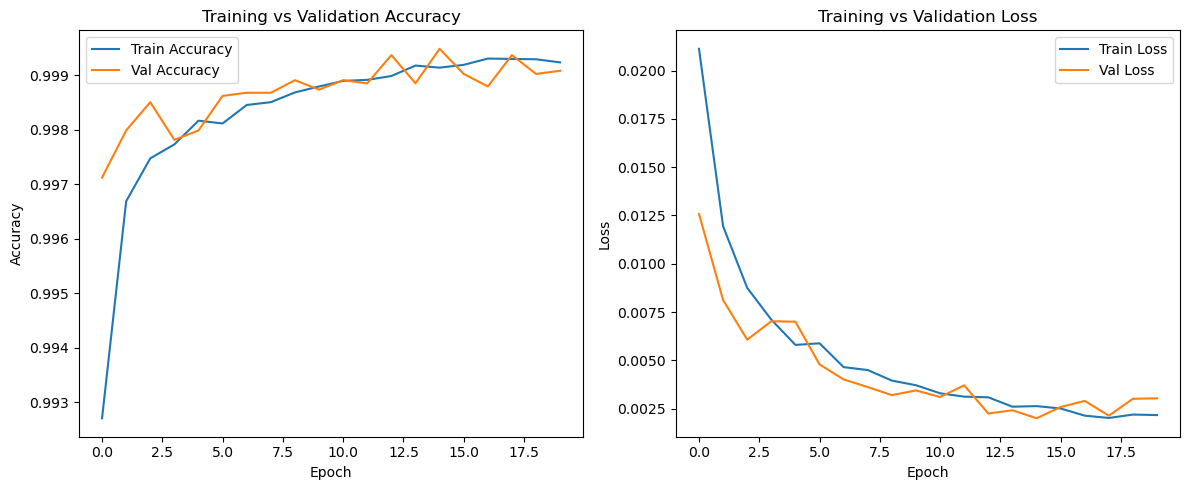

In [ ]:
# 8. Evaluation of the LSTM Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
train_history_path = os.path.join(output_folder, "training_history.png")
plt.savefig(train_history_path, bbox_inches='tight')
plt.show()


In [ ]:
# 9. Save Models and Artifacts
# Save the trained LSTM model in the native Keras format
model.save(os.path.join(output_folder, "lstm_model.keras"))
# Save the scaler using joblib
joblib.dump(scaler, os.path.join(output_folder, "scaler.pkl"))
# Optionally, save the training history as a CSV file
history_df = pd.DataFrame(history.history)
history_csv_path = os.path.join(output_folder, "training_history.csv")
history_df.to_csv(history_csv_path, index=False)

print("LSTM model, scaler, and training history saved.")

# 10. Save Evaluation Metrics
with open(os.path.join(output_folder, "evaluation_metrics.txt"), "w") as f:
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
print("Evaluation metrics saved.")


LSTM model, scaler, and training history saved.
Evaluation metrics saved.
